# This is the ACSE-9 Project Jupyter Notebook 

In [3]:
# Sign in to drive to get the data if you are in Google Colab env!
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import deque, namedtuple
import random
import copy
import itertools

import math
import gym
from gym import spaces, logger
from gym.utils import seeding

# pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [5]:
# Set font size
plt.rc('font', size=20) 

# ESS Modules

In [6]:
# This module contains all the Energy Storage Systems module types, such as Li ion battery, hydrogen storage etc

class simple_battery:
    def __init__(self, capacity=500e3, efficiency=0.95, power=20e3):
        self.capacity = capacity
        self.charge_efficiency = efficiency
        self.discharge_efficiency = efficiency
        self.energy_state = 200e3
        self.power = power

    def charge(self):

        if self.energy_state == self.capacity:
            return 0

        output_power = self.power
        # Amount of charge obtained from charging with input power
        charge_amount = output_power * self.charge_efficiency

        # Charging amount is constrained by battery capacity
        if self.energy_state + charge_amount > self.capacity:
            # Limit the charged amount such that the capacity is achieved
            charge_amount = self.capacity - self.energy_state
            output_power = charge_amount / self.charge_efficiency
            self.energy_state = self.capacity
        else:
            self.energy_state += charge_amount
        
        return -output_power

    def discharge(self):

        if self.energy_state == 0:
            return 0

        output_power = self.power

        discharge_amount = output_power / self.discharge_efficiency

        if self.energy_state - discharge_amount < 0:
            discharge_amount = self.energy_state
            output_power = discharge_amount * self.discharge_efficiency
            self.energy_state = 0
        else:
            self.energy_state -= discharge_amount
        
        return output_power



class simple_hydrogen:
    def __init__(self, capacity=500e3, efficiency=0.7, power=20e3):
        self.capacity = capacity
        self.charge_efficiency = efficiency
        self.discharge_efficiency = efficiency
        self.energy_state = 200e3
        self.power = power

    def charge(self):

        if self.energy_state == self.capacity:
            return 0

        output_power = self.power
        # Amount of charge obtained from charging with input power
        charge_amount = output_power * self.charge_efficiency

        # Charging amount is constrained by battery capacity
        if self.energy_state + charge_amount > self.capacity:
            # Limit the charged amount such that the capacity is achieved
            charge_amount = self.capacity - self.energy_state
            output_power = charge_amount / self.charge_efficiency
            self.energy_state = self.capacity
        else:
            self.energy_state += charge_amount
        
        return -output_power

    def discharge(self):

        if self.energy_state == 0:
            return 0

        output_power = self.power

        discharge_amount = output_power / self.discharge_efficiency

        if self.energy_state - discharge_amount < 0:
            discharge_amount = self.energy_state
            output_power = discharge_amount * self.discharge_efficiency
            self.energy_state = 0
        else:
            self.energy_state -= discharge_amount
        
        return output_power

# Generator

In [7]:
class generator():
    def __init__(self, capacity=20e3):
        self.capacity = capacity

    def generate_power(self):
        return self.capacity

# Utils

In [8]:
def load_data(data_path, mode):
    # Variables 
    target_population = 80e3  # population of Isle of Man
    input_population = 70e6  # population of UK

    # Load the power data
    solar_data = pd.read_csv(data_path + 'ninja_pv_25MW.csv', header=3)
    wind_data = pd.read_csv(data_path + 'ninja_wind_80MW.csv', header=3)

    # Solar and Wind power is in kW
    solar_power = solar_data['electricity']
    wind_power = wind_data['electricity']

    load_power = None

    if mode == 'train' or mode == 'tune':
        # Need to scale the UK demand to the population of Isle of Man target 
        load_power = pd.read_csv(data_path + 'gridwatch2019.csv')[' demand'] * target_population / input_population * 1000  # multiplied by 1000 because of unit conversion from MW to kW

    elif mode == 'eval':
        load_power = pd.read_csv(data_path + 'gridwatch2020.csv')[' demand'] * target_population / input_population * 1000  # multiplied by 1000 because of unit conversion from MW to kW


    # Need to generate synthetic 
    # Start with having the power generated be varying with 5% from the initial data
    # Conatenate together the dataframes
    if mode == 'train' or mode == 'tune':
        
        load_extended = load_power.append(load_power)
        solar_extended = solar_power.append(solar_power)
        wind_extended = wind_power.append(wind_power)

        # Clean data from outlyers
        load_extended = load_extended[load_extended[:] > 15e3]
        # Load is in precision of 5 min, change this to 1 hour by picking every 12th element
        load_extended = load_extended[::12]
        load_extended = load_extended.reset_index(drop=True)  # reset the index due to slicing

        # Limit the number of points the available number of load data
        solar_extended = solar_extended[:len(load_extended)]
        wind_extended = wind_extended[:len(load_extended)]

        # Add some random noise of +-10%
        random_noise_load = np.random.uniform(-0.1, 0.1, len(load_extended))
        random_noise_solar = np.random.uniform(-0.1, 0.1, len(load_extended))
        random_noise_wind = np.random.uniform(-0.1, 0.1, len(load_extended))

        load_full = load_extended + load_extended * random_noise_load
        solar_full = solar_extended + solar_extended * random_noise_solar
        wind_full = wind_extended + wind_extended * random_noise_wind

        return solar_full.to_numpy(), wind_full.to_numpy(), load_full.to_numpy()

    elif mode == 'eval':
        # Clean data from outlyers
        load_power = load_power[load_power[:] > 15e3]
        # Need to only take data from the hourly readings, not every 5 min. Need to thus take only every 12th entry
        load_adjusted = load_power[::12]
        
        # Get only the power column and the same number of data points as for load 
        load_adjusted = load_adjusted[:len(solar_power)] 
        # Reset the sliced index
        load_adjusted = load_adjusted.reset_index(drop=True)

        return solar_power, wind_power, load_adjusted

    else:
        raise Exception('Incorrect Mode!')

In [9]:
class Logger:
    def __init__(self, mode='train'):
        self.mode = mode
        if mode == 'train':
            self.total_rewards = []
            self.loss_values = []
        elif mode == 'eval':
            self.rewards = []
            self.total_supply_power = []
            self.solar_power = []
            self.wind_power = []
            self.load = []
            self.power_ess1 = []
            self.power_ess2 = []
            self.power_generator = []
            self.ess1_charge_states = []
            self.ess2_charge_states = []
            self.power_loss = 0
        else:
            raise('Set correct mode!')

    def reset(self):
        if self.mode == 'train':
            self.total_rewards.clear()
            self.loss_values.clear()
        elif self.mode =='eval':
            self.rewards.clear()
            self.total_supply_power.clear()
            self.solar_power.clear()
            self.wind_power.clear()
            self.load.clear()
            self.power_ess1.clear()
            self.power_ess2.clear()
            self.power_generator.clear()
            self.ess1_charge_states.clear()
            self.ess2_charge_states.clear()
            self.power_loss = 0

    def push_log_train(self, loss):
        if loss == None:
            return
        else:
            self.loss_values.append(loss)
 

    def push_log_eval(self, reward, total_supply_power, solar_power, wind_power, load, 
                                    power_ess1, power_ess2, power_generator, ess1_charge_states, ess2_charge_states, power_loss):
        self.rewards.append(reward)
        self.total_supply_power.append(total_supply_power)
        self.solar_power.append(solar_power)
        self.wind_power.append(wind_power)
        self.load.append(load)
        self.power_ess1.append(power_ess1)
        self.power_ess2.append(power_ess2)
        self.power_generator.append(power_generator)
        self.ess1_charge_states.append(ess1_charge_states)
        self.ess2_charge_states.append(ess2_charge_states)

        if power_loss == True:
            self.power_loss += 1


    def plot_loss(self):
        fig = plt.figure(figsize=(15, 10))
        ax = fig.add_subplot(111)

        ax.plot(np.arange(0, len(self.loss_values)), self.loss_values, label='Loss value')
        ax.set_title('Loss values')

        plt.show()


    def plot_eval_all(self):
        if (self.mode == 'train'):
            return

        time = np.arange(0, len(self.rewards))
        
        fig1 = plt.figure(figsize=(15, 10))
        ax1 = fig1.add_subplot(111)

        fig2 = plt.figure(figsize=(15, 10))
        ax2 = fig2.add_subplot(111)

        fig3 = plt.figure(figsize=(15, 10))
        ax3 = fig3.add_subplot(111)

        # Plot the rewards over time
        ax1.plot(time, self.rewards)
        ax1.set_xlabel('Time [h]')
        ax1.set_ylabel('Reward value')

        # Plot total supply power vs load
        ax2.plot(time, self.load, label='Load Power')
        ax2.plot(time, self.total_supply_power, label='Total Supply Power')
        ax2.set_xlabel('Time [h]')
        ax2.set_ylabel('Total Supply Power [kW]')
        ax2.legend(loc='best')

        # Plot the charge state of the ess modules
        ax3.plot(time, self.ess1_charge_states, label='battery energy state')
        ax3.plot(time, self.ess2_charge_states, label='hydrogen energy state ')
        ax3.set_xlabel('Time [h]')
        ax3.set_ylabel('Energy [MWh]')
        ax3.legend(loc='best')


        print('Number of power_losses = {}'.format(self.power_loss))
        plt.show()

    


        
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = True

    return True

def plot_total_rewards(total_rewards, num_episodes):
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111)

    # Plot time
    ax.plot(np.arange(0, num_episodes), total_rewards, linewidth=5)
    ax.set_xlabel('Episode number')
    ax.set_ylabel('Total Reward')
    
    plt.show()

  

# Financial Reward

In [10]:
class FinancialModel:
    """ Financial model for reward function

    Returns: Operational revenue (revenue minus costs, maintainance and penalties) from operating a HRES system

    Consumer electricity price taken from https://www.manxutilities.im. Price and costs are in british pounds per kWh:
    Electricity price = 16.9 p for kWh or 0.169£
    Generator cost = 20p for kWh or 0.2£
    ESS maintainance cost = 200£ for 1h of usage
    Power deficit cost = 10p per kWh or 0.1£
    Power loss penalty (fixed) = 1500£

    """

    def __init__(self, electricity_price=0.169, generator_cost=0.2, ess_cost=100, deficit_cost=0.2, surplus_cost=0.1, power_loss_penalty=1000):
        self.electricity_price = electricity_price  # price per kWh
        self.generator_cost = generator_cost
        self.ess_cost = ess_cost
        self.surplus_cost = surplus_cost
        self.deficit_cost = deficit_cost
        self.power_loss_penalty = power_loss_penalty

    def get_reward(self, total_power, load, action, generator_power):
        
        revenue = 0
        demanded_power = 0
        power_loss = False
        power_difference = total_power - load

        # Calculate how much power was demanded, limit is given by the load
        if total_power - load >= 0:
            demanded_power = load
        else:  # limit to load amount if power supply exceeds it
            demanded_power = total_power

        # Demanded power revenue
        revenue += self.electricity_price * demanded_power

        # Deficit cost
        if power_difference < 0:
            revenue -= self.deficit_cost * abs(power_difference)

        # Surplus cost
        if power_difference > 0:
            revenue -= self.surplus_cost * abs(power_difference)
        
        # Power loss penalty
        if power_difference < 0:
            revenue -= self.power_loss_penalty
            power_loss = True

        # Maintanance costs
        if action[0] > 0:  # ess1 cost
            revenue -= self.ess_cost
        if action[1] > 0:  # ess2 cost
            revenue -= self.ess_cost

        # Generator cost
        if generator_power > 0:
            revenue -= self.generator_cost * generator_power

        return revenue, power_loss


# Environment


In [11]:
class HRES():
    """ 
    Description:
        An environment model of the Hybrid Renewable Energy Power Plant (HRES) [Solar + Wind] with hybrid Energy Storage System (ESS). Solar PV and wind turbines generate power 
        with data read to the class at initialization including the load data.py

        Observable state:
        - solar generated power in kW
        - wind generated power in kW
        - load data in kW
        - charge state of ESS 1
        - charge state of ESS 2

        Available Actions:
        - 3 element action array consisting of: do nothing, charge , discharge actions for both ess1 and ess2 modules, generator off/on,
            thus resulting in 18 distinct combinations and actions.
    """

    # Initialization function
    def __init__(self, data_path, mode='train', reward='revenue'):
        # Set the mode to either training or application
        self.mode = mode
        
        # Input files
        # Load the power data
        self.solar_power, self.wind_power, self.load = load_data(data_path, self.mode)
        self.data_size = len(self.load)
        
        # Total power
        # self.hybrid_power = self.solar_power + self.wind_power
        
        # Energy storage system, initialized with default values
        self.ess1 = simple_battery()
        self.ess2 = simple_hydrogen()

        # Backup generator
        self.generator = generator()

        # Action space
        self.action_space = [[ess1, ess2, gen] for ess1 in [-self.ess1.power, 0, self.ess1.power] for ess2 in [-self.ess2.power, 0, self.ess2.power] for gen in range(2)]

        # Reward function
        self.reward_type = reward
        if self.reward_type == 'revenue':
            self.reward_model = FinancialModel()  # initialize with default values
        else:
            raise Exception('Incorrect mode!')

        # Timestep counter
        self.time = 0
        
        # Flag to determine if the time duration for training is done
        self.is_done = False
        
        self.state = None

        self.total_rewards = 0

        # Data Logger
        if self.mode == 'eval':
            self.logger = Logger(self.mode)
            self.reward_record = []
    

    # **************** UTILS *******************************
    
    # Function to set the random seed
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
    
    # Function which resets the state of the environment to initial values at t=0
    def reset(self):
        self.ess1.energy_state = 200e3
        self.ess2.energy_state = 200e3
        self.time = 0
        self.total_rewards = 0
        self.reward_record = []
        
        if self.mode == 'eval':
            self.logger.reset()

        # reset and initialize the first state
        self.state = np.array([self.solar_power[self.time], self.wind_power[self.time], self.load[self.time], 
                                        self.ess1.energy_state, self.ess2.energy_state], dtype=np.float32)
    
    
    # ***************** STATE TRANSITIONS ***********************

    
    # Function which return the current state of the environment
    def observe(self):
        return np.array([self.solar_power[self.time], self.wind_power[self.time], self.load[self.time], 
                                        self.ess1.energy_state, self.ess2.energy_state], dtype=np.float32)


    def perform_action(self, action_index):

        # From the input action index, get the action array from avaialble action space
        action = self.action_space[action_index]

        # Positive power is dicharge, negative power is charge
        power_ess1 = 0
        power_ess2 = 0
        power_generator = 0

        if action[0] == -self.ess1.power:  # charge ess1
            power_ess1 = self.ess1.charge()
        elif action[0] == self.ess1.power:  # discharge ess1
            power_ess1 = self.ess1.discharge()
        else:  # ess1 does nothing
            pass

        if action[1] == -self.ess2.power:  # charge ess2
            power_ess2 = self.ess2.charge()
        elif action[1] == self.ess2.power:  # discharge ess2
            power_ess2 = self.ess2.discharge()
        else:  # ess2 does nothing
            pass
        
        if action[2] == 1:
            power_generator = self.generator.generate_power()


        # ************* REWARDS **************

        reward = 0
        power_loss = False

        total_supply_power = self.solar_power[self.time] + self.wind_power[self.time] + power_ess1 + power_ess2 + power_generator
        
        if self.reward_type == 'revenue':  # financial reward
            reward, power_loss = self.reward_model.get_reward(total_supply_power, self.load[self.time], action, power_generator)

        
        # If in evaluation mode, append to the logger object
        if self.mode == 'eval':
            # Log the data
            self.logger.push_log_eval(reward, total_supply_power, self.solar_power[self.time], self.wind_power[self.time],
                                        self.load[self.time], power_ess1, power_ess2, power_generator, self.ess1.energy_state, self.ess2.energy_state, power_loss)

        return reward

    # Step function, which will update the environment state and returns the reward for the action
    def step(self, action):
        
        # Perform the action
        reward = self.perform_action(action)

        # Update time counter
        self.time += 1

        # Observe the next state
        next_state = self.observe()

        if self.mode == 'eval':
            self.reward_record.append(reward)
        
        # Add the reward to the cumulative pool
        self.total_rewards += reward 
        
        return reward, next_state
        

    # Function to plot the evolution of the environement e.g. power delivered
    # Time in hours
    def plot_data(self, time_start, time_end):
        
        time_duration = time_end - time_start
        # demand_precision = 12  # 5 min precision for demand

        # Get data
        wind_data = self.wind_power[time_start:time_end]
        solar_data = self.solar_power[time_start:time_end]  # need to multiply by 12 such that 5 min data can be transformed to hourly
        load_data = self.load[(time_start):(time_end)]

        # Time data
        time = np.arange(time_start, time_end, 1)

        fig1 = plt.figure(figsize=(15, 10))
        ax1 = fig1.add_subplot(111)

        fig2 = plt.figure(figsize=(15, 10))
        ax2 = fig2.add_subplot(111)

        # Plot the data
        ax1.plot(time, wind_data, label='wind')
        ax1.plot(time, solar_data, label='solar')
        ax1.plot(time, load_data, label='demand')
        
        # Legend
        ax1.legend(loc='best')
        ax1.set_title('Data from {} h to {} h'.format(time_start, time_end))

        # Plot the difference between the renewable output and the demand
        deficit = np.array(wind_data) + np.array(solar_data)- np.array(load_data)


        # print(len(deficit))
        ax2.plot(time, deficit, label='deficit')
        ax2.set_title('Power deficit from {} h to {} h'.format(time_start, time_end))

        plt.show()

    def plot_rewards(self, end_time):

        fig = plt.figure(figsize=(15, 10))
        ax = fig.add_subplot(111)

        # Plot time
        ax.plot(np.arange(0, end_time), self.reward_record)
        ax.set_xlabel('Time [h]')
        ax.set_ylabel('Reward')
        
        plt.show()

# DQN

In [12]:
class DQN(nn.Module):
    """ 
        Deep Q Neural Network. 
        The inputs are:
        - PV power generated
        - Wind power generated
        - Load
        - State of charge in ESS1
        - State of Charge in ESS2

        The outputs are 18 actions consisting of:
        - Charge ESS1 / Discharge ESS1
        - Charge ESS2 / Discharge ESS2
        - Use Power Generator
    """
    # Init function
    def __init__(self, observation_space, action_space, l1_size=18, l2_size=90, l3_size=18, l4_size=50):
        # Supercharge the function
        super(DQN, self).__init__()
        self.l1 = nn.Linear(observation_space, l1_size)
        self.l2 = nn.Linear(l1_size, l2_size)
        self.l3 = nn.Linear(l2_size, l3_size)
        self.l4 = nn.Linear(l3_size, l4_size)
        self.activate = nn.ReLU()
        self.output = nn.Linear(l2_size, action_space)

    # Forward function
    def forward(self, x):
        # Put the value to device
        x1 = self.activate(self.l1(x))
        x2 = self.activate(self.l2(x1))
        # x3 = self.activate(self.l3(x2))
        # x4 = self.activate(self.l4(x3))
        return self.output(x2)

# Replay Memory

In [13]:
class ReplayMemory(object):
    def __init__(self, batch_size, capacity=1000):
        # Initialize memoery as the deque container of max size of capacity
        # Deque allows for fast appending and pops / removes
        self.memory = deque(maxlen=capacity)
        self.batch_size = batch_size
        self.experience = namedtuple('Experience', ('state', 'action', 'reward', 'next_state'))

        # Check if the device has available gpu
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


    # Function which returns the length of the memory pool/list
    def __len__(self):
        return len(self.memory)

    # Function to append the transition information to the memory
    def push(self, *args):
        self.memory.append(self.experience(*args))

    # Function to randomly sample from the memory pool the batch of size 'batch_size' to be used for optimization
    def sample(self):
        experiences = random.sample(self.memory, self.batch_size)

        # Need to stack the experience fields into tensors
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).type(torch.int64).to(self.device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).type(torch.int64).to(self.device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(self.device)

        return (states, actions, rewards, next_states)



# Agent

In [14]:
class Agent():

    def __init__(self, observation_size=5, action_size=18,batch_size=50, memory_size=2000, lr=1e-3, tau=1e-3, gamma=0.90, mode='train', 
                                saved_path=None, eps_start=1, eps_end=0.1, eps_decay=5e4, learn_every=10):
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.mode = mode
        self.observation_size = observation_size
        self.action_size = action_size

        if self.mode == 'train':
            # Q-Network
            self.policy_net = DQN(observation_size, action_size).to(self.device)
            self.target_net = copy.deepcopy(self.policy_net).to(self.device)

            # Freeze the parameters in the target network
            for param in self.target_net.parameters():
                param.requires_grad = False

            # Epsilon-Greedy rate
            self.eps_start = eps_start
            self.eps_end = eps_end
            self.eps_decay = eps_decay

            self.gamma = gamma
            self.tau = tau

            # Q-learning
            self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr, weight_decay=1e-4)
            self.loss = torch.nn.SmoothL1Loss()
            self.batch_size = batch_size
            self.memory = ReplayMemory(self.batch_size, capacity=memory_size)
            self.steps_done = 0

            self.min_exp = 5 * self.batch_size  # min number of experiences before agent learns
            self.learn_every = learn_every

        elif self.mode == 'eval' and saved_path != None:
            # Create the model and load the pretrained state dictionary
            self.model = DQN(observation_size, action_size).to(self.device)
            self.model.load_state_dict(torch.load(saved_path, map_location=self.device))
            self.model.eval()

        else:
            raise('Incorrect mode!')     

    # Function which will select the action based on the epsilon-greedy method
    def select_action(self, state):
        """ 
        Returns action for a given state given the current policy. Method uses decaying epsilon-greedy method.
        """
        # Create state tensor
        state = torch.from_numpy(state).float().to(self.device)
    
        # If in evaluation mode, only propagate through the model and obtain the action index
        if self.mode == 'eval':
            with torch.no_grad():
                # Forward pass the state through the network
                result = self.model(state)

                # Obtain the action idex through the maximum of the estimated Q-values
                action_index = torch.argmax(result).cpu().numpy()
                return action_index

        # Calculate the epsilon value with decay, for every eps_decay steps, the epsilon decays by factor of 1 / e
        eps_threshold = self.eps_end + (self.eps_start - self.eps_end) * math.exp(-1 * self.steps_done / self.eps_decay)
        # eps_threshold = 0.2

        # Based on the sample, do either exploration (sample > epsilon) or exploitation
        sample = random.random()

        # Initialize
        action_index = 0
        
        # Exploit the existing policy network
        if sample > eps_threshold:
            with torch.no_grad():
                # Forward pass the state through the network
                result = self.policy_net(state)

                # Obtain the action idex through the maximum of the estimated Q-values
                action_index = torch.argmax(result).cpu().numpy()
        else:
            # Explore using random sampling from the action space
            action_index = random.choice(np.arange(0, self.action_size))
            
        return action_index


    # Estimate of the Q-value for the current state
    def td_estimate(self, states, actions):
        current_Q = self.policy_net(states).gather(1, actions)
        return current_Q.squeeze()

    # Estimation of the the target Q-value from the Bellman's Equation for optimal policy
    def td_target(self, rewards, next_states):
        # Obtain the Q-values for the next stake achieved with action taken by the current, best policy
        next_state_Qs = self.policy_net(next_states)

        # Find the best action based on the policy Q-values, resize so they could be used for indexing 
        best_actions = torch.argmax(next_state_Qs, axis=1).resize_(self.batch_size, 1)

        # Find the Q-value of the next state indexed for batch and best action for current policy
        next_Qs = self.target_net(next_states).gather(1, best_actions)
        target_Qs = rewards + self.gamma * next_Qs
        return target_Qs.squeeze()


    # Function to perform the soft updates between the policy and target networks
    def soft_update(self, tau):
        """
        Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            policy_net (PyTorch Neural Network): weights will be copied from
            target_net (PyTorch Neural Network): weights will be copied to
            tau (float): interpolation parameter to update the weights between both networks
        """
        # Perform the soft updates on the parameters of the policy and target networks
        for target_param, policy_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(tau*policy_param.data + (1.0-tau)*target_param.data)


    def step(self, state, action, reward, next_state):

        # Push the experience to the memory buffer 
        self.memory.push(state, action, reward, next_state)

        # Learn every UPDATE_EVERY time steps.
        self.steps_done += 1

        # Initialize
        loss = None

        if self.steps_done % self.learn_every == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.min_exp:
                experiences = self.memory.sample()
                loss = self.learn(experiences)

        return loss



    def learn(self, experiences):
        """ Functions which performs Q-learning on the batch experiences with gamma discount rates. """

        # Unpack the experiences
        states, actions, rewards, next_states = experiences

        # Calculate the expected and the target Q values from policy and target networks
        Q_expected = self.td_estimate(states, actions)

        Q_targets = self.td_target(rewards, next_states)

        # Compute the loss function
        loss = self.loss(Q_expected, Q_targets)

        # Set the gradients of optimizer to zero
        self.optimizer.zero_grad()

        # Do the backwards propagation
        loss.backward()
        
        # Step using the optimizer and update using gradient descent
        self.optimizer.step()

        # Perform a soft update on target network model parameters from the policy network
        self.soft_update(self.tau)

        return loss.item()

    # Function to save the state dictionary of the policy network
    def save(self, save_path):
        if save_path is not None:
            torch.save(self.policy_net.state_dict(), save_path)

# Hyperparameter Tunning

In [98]:
# Function used to tune hyperparameters
def tune_parameters():
    # Hyper Parameter lists
    batch_sizes = [50]
    memory_sizes = [5000] 

    lrs = [1e-3, 2e-3, 5e-3]
    learn_everys = [10, 20, 30]
    gammas = [0.9]
    eps_start = 1
    eps_end = 0.1
    eps_decays = [150e3]
    taus = [1e-3, 3e-3, 5e-3]

    seed = 42
    set_seed(42)

    data_path = 'drive/MyDrive/ACSE-9_data/'

    # Initialize the environment
    env = HRES(data_path, mode='train')

    # Episodes
    ep_num = 50

    # Results
    results = pd.DataFrame(columns=['batch_size', 'memory_size', 'lr', 'tau', 'learn_every', 'sync_every', 'gamma', 'eps_decay', 'max_reward', 'last_reward'])
    path_to_results = 'drive/MyDrive/ACSE-9_data/'

    print('Starting Hyper Search...')
    num = 0

    # Loops through the specified
    for batch_size, memory_size, lr, tau, learn_every, gamma, eps_decay in itertools.product(batch_sizes, memory_sizes, lrs, taus, learn_everys, gammas, eps_decays): 

        print('Tunning ep: ', num)
        print('Config:  lr={}, tau={}, learn_every={}'.format(lr, tau, learn_every))

        # Create new agent
        agent = Agent(batch_size=batch_size, memory_size=memory_size, lr=lr, tau=tau,
                        learn_every=learn_every, gamma=gamma, 
                            eps_start=eps_start, eps_end=eps_end, eps_decay=eps_decay)


        # ************* TRAINING LOOP ***********************

        total_rewards = []
        max_reward = -10e6  # some large negative number

        # Loop over the specified number of episodes
        for ep in range (ep_num):

            # reset the env at the begining of each episode
            env.reset()

            # Make the initial state observation
            state = env.observe()

            for time in range(env.data_size-1):    

                # Select the action based on epsilon-greedy policy
                action = agent.select_action(state)

                # Based on the selected action, perform the temporal action step within the environment
                reward, next_state = env.step(action)

                # Perform the temporal step in agent experience sampling and training
                loss = agent.step(state, action, reward, next_state)

                # Make the next state the current state and repeat
                state = next_state

            # Append the accumulated training total rewards to the tracker
            total_rewards.append(env.total_rewards)
            
        max_reward = max(total_rewards)

        last_reward = env.total_rewards
        config = {'batch_size':batch_size, 'memory_size':memory_size, 'lr':lr, 'tau':tau, 'learn_every':learn_every, 'sync_every':sync_every, 
                  'gamma': gamma, 'eps_decay':eps_decay, 'max_reward':max_reward, 'last_reward': last_reward}

        results = results.append(config, ignore_index=True)
        num += 1

    # Save results to csv
    print('Saving results to csv!')
    results.to_csv(path_to_results + 'tune_results_{}_eps.csv'.format(ep_num))


In [99]:
# Call the tunning function  
# DISCLAIMER the tau and learn every in the cell bellow should be swaped!
# tune_parameters()

# Baselines

In [15]:
class RandomControl:
    def __init__(self, action_size):
      self.action_size = action_size
    
    def select_action(self, state):
        return random.choice(np.arange(0, self.action_size))

In [16]:
class RuleBasedControl:
    def __init__(self, ess1_capacity, ess2_capacity, ess1_power, ess2_power, action_space):
        self.ess1_capacity = ess1_capacity
        self.ess2_capacity = ess2_capacity
        self.ess1_power = ess1_power
        self.ess2_power = ess2_power
        self.action_space = action_space

    # Rule-based controller which performs actions based on the state
    def select_action(self, state):
        
        power_balance = state[0] + state[1] - state[2]  # solar + wind - load

        # tracking variable
        available_power = power_balance

        action = [0, 0, 0]

        # Use nominal power outputs of ESS modules
        # If batery charge/discharge is available, use battery to charge/discharge
        # If afterwards, hydrogen charge/discharge is available, use hydrogen to charge/discharge is available
        # If after all this discharge, we still have deficit, use generator energy

        # Charge if power balance is positive battery is not full
        if power_balance > 0:
            if state[3] != self.ess1_capacity:
                action[0] = -20e3  # charge to batteries
                available_power -= self.ess1_power  # subtract from tracking variable
            if available_power > self.ess2_power:
                action[1] = -20e3  # charge to hydrogen storage
            return self.action_space.index(action)

        # Discharge if power balance is negative
        if power_balance < 0:
            if state[3] != 0:
                  action[0] = 20e3  # discharge from batteries
                  available_power += self.ess1_power  # add to tracking variable
            if available_power < -self.ess2_power:
                if state[4] != 0:
                    action[1] = 20e3  # discharge from hydrogen storage
                    available_power += self.ess2_power
            if available_power < 0:  # use generator if there is sill some demanded power left 
                action[2] = 1  # use generator
            return self.action_space.index(action)

# Training


In [44]:
def training(env, agent, ep_num, save_path):

    logger = Logger()

    print('Starting Training')

    # ************* TRAINING LOOP ***********************

    total_rewards = []

    # Loop over the specified number of episodes
    for ep in range (ep_num):

        print('ep = {}'.format(ep))
        # reset the env at the begining of each episode
        env.reset()

        # Make the initial state observation
        state = env.observe()

        for time in range(env.data_size-1):    

            # Select the action based on epsilon-greedy policy
            action = agent.select_action(state)

            # Based on the selected action, perform the temporal action step within the environment
            reward, next_state = env.step(action)

            # Perform the temporal step in agent's experience sampling and training
            loss = agent.step(state, action, reward, next_state)

            logger.push_log_train(loss)

            # Make the next state the current state and repeat
            state = next_state

        # Append the accumulated training total rewards to the tracker
        total_rewards.append(env.total_rewards)

    print('Saving model...')
    # Save the model's state dictionary 
    agent.save(save_path)

    # Print the maximum training reward
    print('Maximum episode reward = ', max(total_rewards))

    return total_rewards, logger


# Training Loop

In [20]:
# TRAINING
seed = 42
set_seed(42)

# Paths to data in you drive, edit this to suit your system
save_path = 'drive/MyDrive/ACSE-9_data/trained_model_example_revenue'
data_path = 'drive/MyDrive/ACSE-9_data/'

# Initialize the environment
env = HRES(data_path, reward='revenue')

In [60]:
# Hyper Parameters
batch_size = 50
memory_size = 5000
lr = 1e-3
learn_every = 20
gamma = 0.9
eps_start = 1 
eps_end = 0.1
eps_decay = 150000
tau = 1e-3

# Set up the agent with a given set of hyperparameters
agent = Agent(batch_size=batch_size, memory_size=memory_size, lr=lr,tau=tau, learn_every=learn_every,
                                                    gamma=gamma, eps_start=eps_start, eps_end=eps_end, eps_decay=eps_decay)

# Number of episodes
ep_num = 80

# Perform training
total_rewards, logger = training(env, agent, ep_num, save_path)

Starting Training
ep = 0
ep = 1
ep = 2
ep = 3
ep = 4
ep = 5
ep = 6
ep = 7
ep = 8
ep = 9
ep = 10
ep = 11
ep = 12
ep = 13
ep = 14
ep = 15
ep = 16
ep = 17
ep = 18
ep = 19
ep = 20
ep = 21
ep = 22
ep = 23
ep = 24
ep = 25
ep = 26
ep = 27
ep = 28
ep = 29
ep = 30
ep = 31
ep = 32
ep = 33
ep = 34
ep = 35
ep = 36
ep = 37
ep = 38
ep = 39
ep = 40
ep = 41
ep = 42
ep = 43
ep = 44
ep = 45
ep = 46
ep = 47
ep = 48
ep = 49
ep = 50
ep = 51
ep = 52
ep = 53
ep = 54
ep = 55
ep = 56
ep = 57
ep = 58
ep = 59
ep = 60
ep = 61
ep = 62
ep = 63
ep = 64
ep = 65
ep = 66
ep = 67
ep = 68
ep = 69
ep = 70
ep = 71
ep = 72
ep = 73
ep = 74
ep = 75
ep = 76
ep = 77
ep = 78
ep = 79
Saving model...
Maximum episode reward =  55732486.75030838


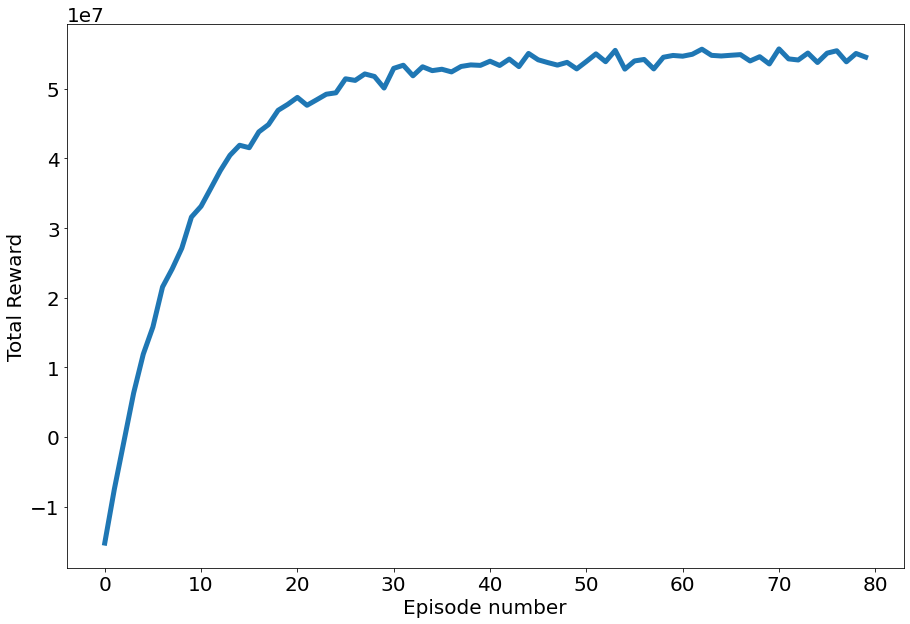

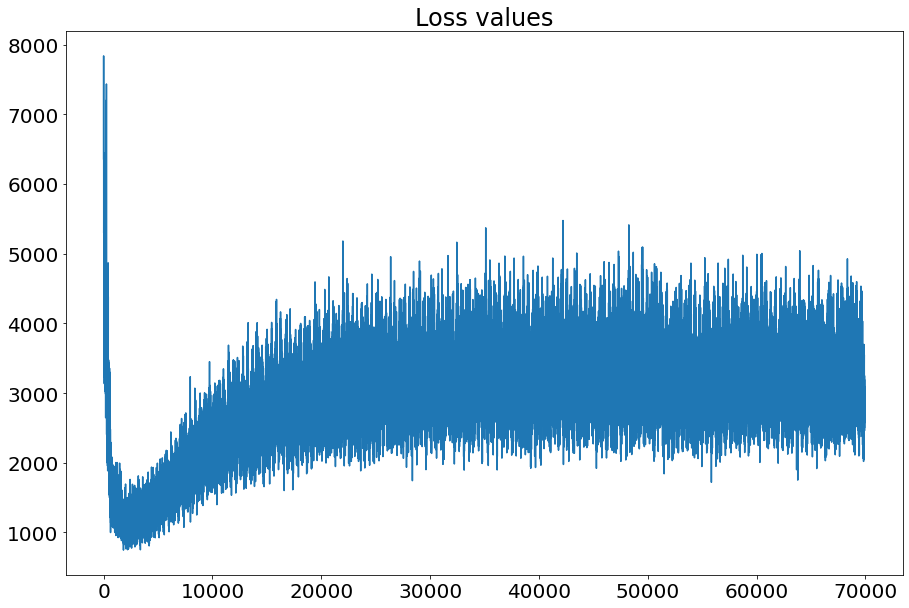

In [62]:
# Plot the change in total rewards over the episodes run
plot_total_rewards(total_rewards, ep_num)   
logger.plot_loss()

# Application

In [17]:
def apply_model(env_apply, data_path, model_path, type='rl'):
    
    env = copy.deepcopy(env_apply)

    agent = None
    if type == 'rl':
        agent_apply = Agent(mode='eval', saved_path=model_path)
    elif type == 'random':
        agent_apply = RandomControl(len(env_apply.action_space))
    elif type == 'rule':
        agent_apply = RuleBasedControl(env_apply.ess1.capacity, env_apply.ess2.capacity, env_apply.ess1.power, env_apply.ess2.power, env_apply.action_space)

    print('Starting Evaluation...')

    env.reset()

    state = env.observe()

    rewards = 0
    logger = Logger()

    # rule_controller = RuleBasedControl(env_apply.ess1.capacity, env_apply.ess2.capacity, env_apply.ess1.power, env_apply.ess2.power, env_apply.action_space)

    for time in range(env_apply.data_size-1):    

        # Select the action based on epsilon-greedy policy
        action = agent_apply.select_action(state)

        # Based on the selected action, perform the temporal action step within the environment
        reward, next_state = env.step(action)

        # Make the next state the current state and repeat
        state = next_state

        rewards += reward

    print('total reward = ',rewards)
    logger = copy.deepcopy(env.logger)
    # At the end plot the results
    return logger



In [18]:
data_path = 'drive/MyDrive/ACSE-9_data/'
model_path = 'drive/MyDrive/ACSE-9_data/trained_model_example_revenue'

# Initialize the environment the application environement
env_apply = HRES(data_path, mode='eval', reward='revenue')

In [22]:
# Call the function
logger_eval_rl = apply_model(env_apply, data_path, model_path, type='rl')
logger_eval_rule = apply_model(env_apply,data_path, model_path, type='rule')
logger_eval_random = apply_model(env_apply,data_path, model_path, type='random')

Starting Evaluation...
total reward =  29159987.568393387
Starting Evaluation...
total reward =  22746800.917166058
Starting Evaluation...
total reward =  -12111571.841798855


Number of power_losses = 1298


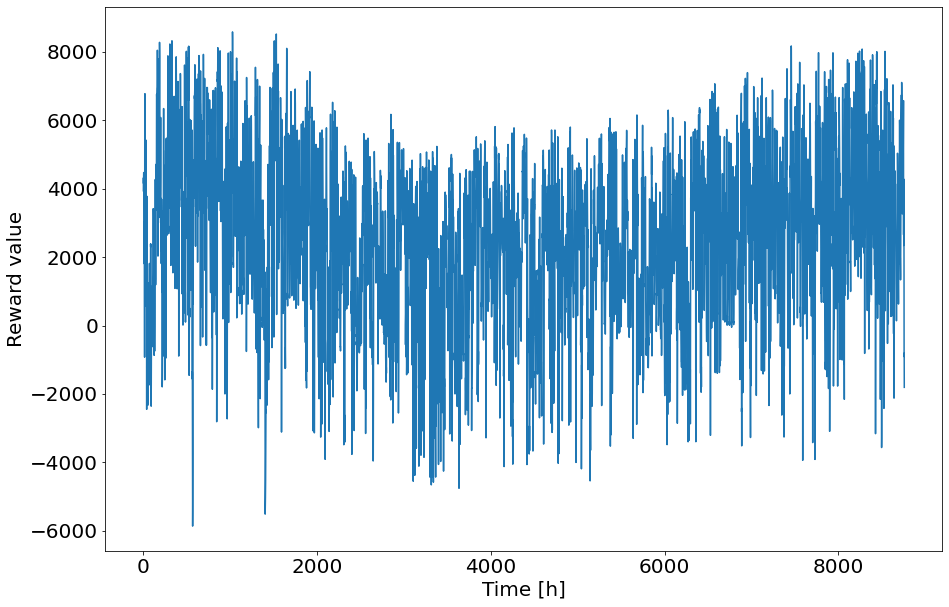

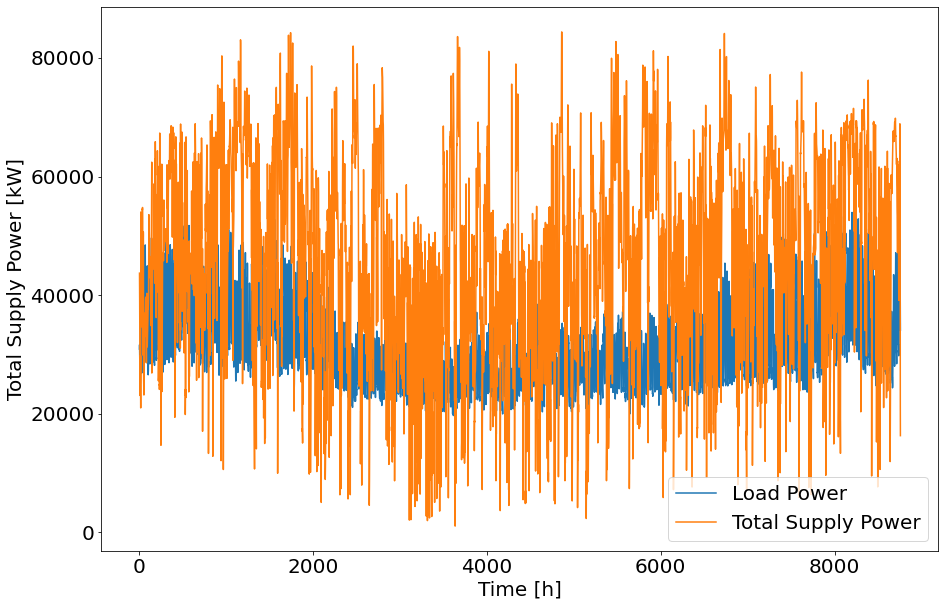

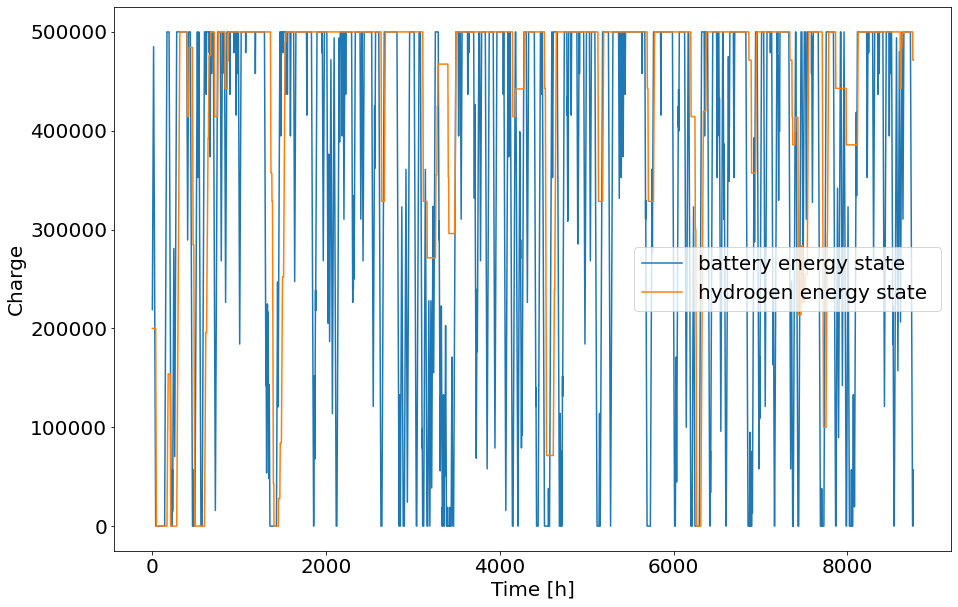

In [303]:
# You can view logs seperately or together, as shown in next cells
logger_eval_rule.plot_eval_all()

In [23]:
# get rewards data
rewards_rl = logger_eval_rl.rewards
rewards_rule = logger_eval_rule.rewards
rewards_random = logger_eval_random.rewards

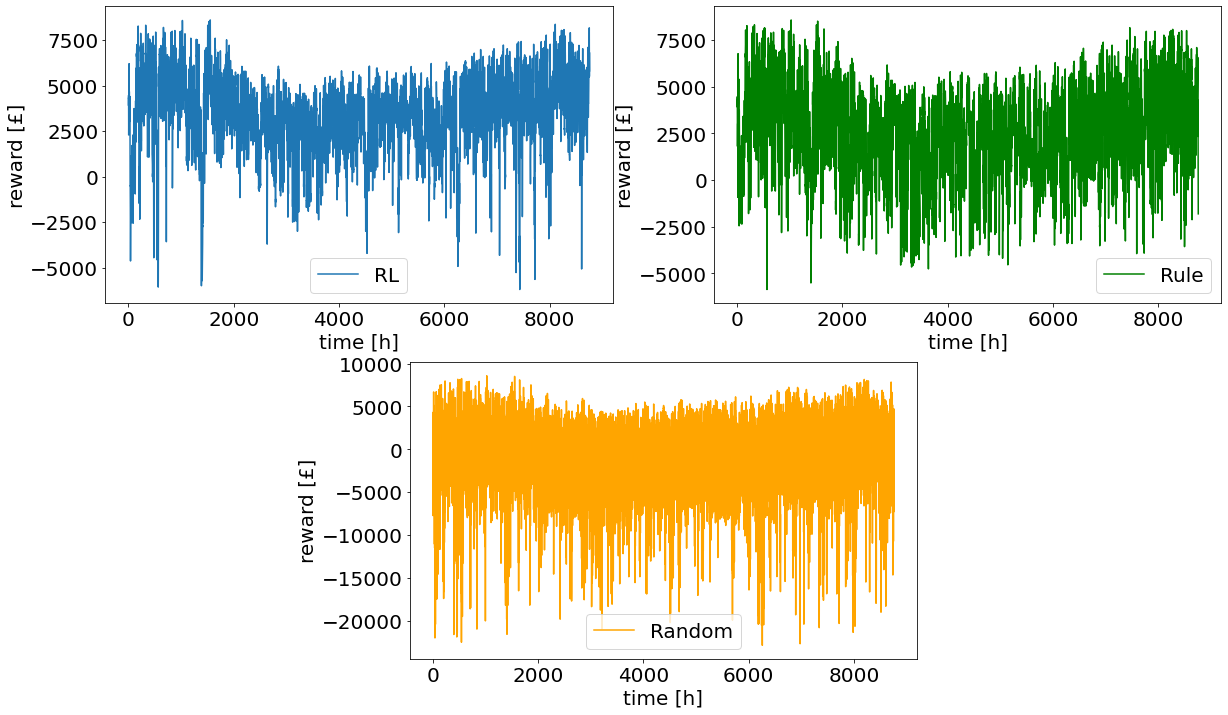

In [25]:
import matplotlib.gridspec as gridspec

time = range(len(rewards_rl))
fig = plt.figure(figsize=(20,12))
gs = gridspec.GridSpec(2, 4, figure=fig)
gs.update(wspace=0.5)
ax1 = plt.subplot(gs[0, :2])
ax2 = plt.subplot(gs[0, 2:])
ax3 = plt.subplot(gs[1, 1:3])
ax1.plot(time, rewards_rl, label='RL')
ax1.set_xlabel('time [h]')
ax1.set_ylabel('reward [£]')
ax2.plot(time, rewards_rule, label='Rule', color='green')
ax2.set_xlabel('time [h]')
ax2.set_ylabel('reward [£]')
ax3.plot(time, rewards_random, label='Random', color='orange')
ax3.set_xlabel('time [h]')
ax3.set_ylabel('reward [£]')

ax1.legend(loc='best')
ax2.legend(loc='best')
ax3.legend(loc='best')

In [164]:
# calculate mean reward, cange this accordingly 
eval_rewards = np.array(logger_eval.rewards)
mean_reward = eval_rewards.mean()
print('mean application reward = ', mean_reward)

mean application reward =  -1326.507935163292
